## **[A Step-by-Step Guide to Feature Engineering for Multivariate Time Series](https://towardsdatascience.com/a-step-by-step-guide-to-feature-engineering-for-multivariate-time-series-162ccf232e2f)**

#### Adding new features based on summary statistics using Python

This is a step-by-step guide to feature engineering for multivariate time series forecasting. You’ll learn how to compute several rolling statistics. Adding these to the explanatory variables often leads to better forecasting performance.

### **Introduction**
#### **Auto-regression**
A multivariate time series contains two or more variables. See below for an example. Often, these data sets are studied with the goal of forecasting one or more of these variables.

In [4]:
import sys
sys.path.insert(0, '../')

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

,PeakP,PeakD,Upcross,SWH,SeaTemp,Hmax,THmax,MCurDir,MCurSpd
time,,,,,,,,,
2022-01-01 00:00:00+00:00,4.010,162.153850,3.890,146.0,10.130833,267.5,4.675,178.051281,0.137000
2022-01-01 01:00:00+00:00,4.130,161.362635,3.925,142.5,10.135000,206.0,4.080,179.882784,0.126000
2022-01-01 02:00:00+00:00,4.085,158.461540,3.855,143.0,10.118333,257.5,4.535,295.648351,0.178667
2022-01-01 03:00:00+00:00,5.985,191.428575,4.075,153.5,10.143333,260.0,8.170,339.413908,0.224333
2022-01-01 04:00:00+00:00,5.970,221.186815,4.305,171.0,10.143333,292.0,4.995,288.586082,0.211667
...,...,...,...,...,...,...,...,...,...
2022-11-23 06:00:00+00:00,6.645,243.076925,4.650,169.0,10.491667,263.5,5.415,122.974360,0.146167
2022-11-23 07:00:00+00:00,5.505,237.142860,4.445,154.0,10.642000,257.5,5.410,147.868134,0.120400
2022-11-23 08:00:00+00:00,5.130,234.769230,4.490,165.0,10.792000,254.0,5.855,106.652014,0.052333


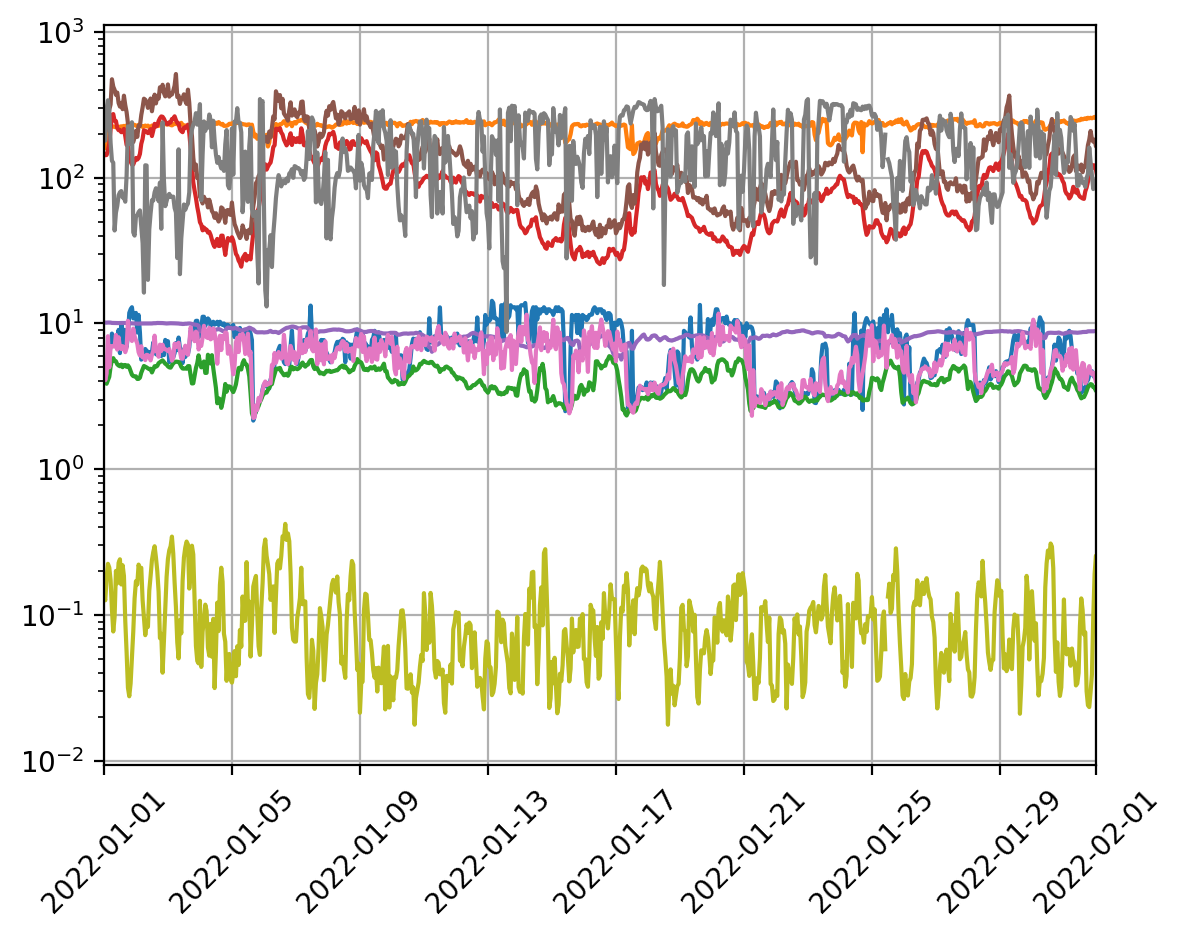

In [5]:
import datetime

# skipping second row, setting time column as a datetime column
buoy = pd.read_csv('data/smart_buoy.csv', 
                skiprows=[1], 
                parse_dates=['time'])

buoy = buoy.drop('station_id', axis = 1)

# setting time as index
buoy.set_index('time', inplace=True)

# resampling to hourly data
buoy = buoy.resample(rule = 'H').mean()

# display(buoy)
# simplifying column names
buoy.columns = [
    'PeakP', 'PeakD', 'Upcross',
    'SWH', 'SeaTemp', 'Hmax', 'THmax',
    'MCurDir', 'MCurSpd'
]

display(buoy)

fig, ax = plt.subplots(dpi = 200)
ax.plot(buoy.index, buoy)
ax.set_yscale('log')
ax.tick_params(axis='x', labelrotation = 45)
ax.grid()
ax.set_xlim([datetime.date(2022, 1, 1), datetime.date(2022, 2, 1)])
plt.show()


Most forecasting models are based on auto-regression. This amounts to solving a supervised learning regression task. The future values of the series are the target variables. The input explanatory variables are the recent past values of each variable.

Auto-regression works under one main assumption. That recent past values contain enough information about the future. But this might not be true.

You can try to extract more information from recent data. For example, rolling summary statistics are helpful in describing recent dynamics.

#### **Automated Feature Engineering**
Feature engineering involves extracting and curating explanatory variables. It is a key stage in any data science project. The quality of the features is a central aspect of the performance of models. Because of this, data scientists spend a lot of time in this process.

Yet, feature engineering is often an ad-hoc process. Data scientists create features based on their domain knowledge and expertise. So, automating part of this process is desirable for practitioners.

Let’s see how you can do this for multivariate time series.

### **Feature Engineering for Multivariate Time Series**
#### **Reading the data**
We’ll use a multivariate time series collected from a smart buoy as a case study [1]. This buoy is placed on the coast of Ireland. It captures 9 variables related to ocean conditions. These include sea temperature, the height of waves, and sea water velocity, among others. Figure 1 above shows the plot for the first month of 2022.

Here’s how you can read this data using pandas:

In [6]:
import pandas as pd

# skipping second row, setting time column as a datetime column
buoy = pd.read_csv('data/smart_buoy.csv', 
                skiprows=[1], 
                parse_dates=['time'])

buoy = buoy.drop('station_id', axis = 1)

# setting time as index
buoy.set_index('time', inplace=True)
# resampling to hourly data
buoy = buoy.resample('H').mean()
# simplifying column names
buoy.columns = [
    'PeakP', 'PeakD', 'Upcross',
    'SWH', 'SeaTemp', 'Hmax', 'THmax',
    'MCurDir', 'MCurSpd'
]

The goal is to forecast the future values of the SWH (significant wave height) variable. This variable is often used to quantify the height of ocean waves. One of the use cases of this problem is to estimate the energy produced from ocean waves. This energy source is an increasingly popular alternative to non-renewable energy sources.

#### **Auto-regressive model**
The time series is multivariate. So, you can use an ARDL (Auto-regressive distributed lags) approach to solve this task.

Here’s how you’d implement this method.

In [7]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor

from src.tde import time_delay_embedding

target_var = 'SWH'

colnames = buoy.columns.tolist()

# create data set with lagged features using time delay embedding
buoy_ds = []
for col in buoy:
    col_df = time_delay_embedding(buoy[col], n_lags=24, horizon=12)
    buoy_ds.append(col_df)

# concatenating all variables
buoy_df = pd.concat(buoy_ds, axis=1).dropna()

# defining target (Y) and explanatory variables (X)
predictor_variables = buoy_df.columns.str.contains('\(t\-')
target_variables = buoy_df.columns.str.contains(f'{target_var}\(t\+')
X = buoy_df.iloc[:, predictor_variables]
Y = buoy_df.iloc[:, target_variables]

# train/test split
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.3, shuffle=False, random_state = 1234)

# fitting a lgbm model without feature engineering
model_wo_fe = MultiOutputRegressor(LGBMRegressor())
model_wo_fe.fit(X_tr, Y_tr)

# getting forecasts for the test set
preds_wo_fe = model_wo_fe.predict(X_ts)

# computing the MAPE error
mape(Y_ts, preds_wo_fe)
# 0.238

0.2643572748139305

First, the time series is transformed into an auto-regressive problem. This is done with the function time_delay_embedding. The predictive goal is to forecast the next 12 values of SWH (horizon=12). The explanatory variables are the past 24 values of each variable in the series (n_lags=24).

A LightGBM is trained for each forecasting horizon using a direct approach. The direct method is a popular approach for multi-step ahead forecasting. It is implemented in scikit-learn with the name MultiOutputRegressor.

The code above builds and tests an auto-regressive model. The explanatory variables include only the recent past values of each variable. This leads to a mean absolute percentage error of 0.238. Let’s see if this score can be improved with feature engineering.

This guide includes two approaches to extract features from multivariate time series:

- **Univariate feature extraction.** Computing rolling statistics of each variable. For example, a rolling average can be used to smooth out spurious observations;
- **Bivariate feature extraction.** Computing rolling statistics of pairs of variables to summarise their interaction. For example, the rolling covariance between two variables.

#### **Univariate Feature Extraction**
You can summarise the recent past values of each variable. For example, computing a rolling average to summarise the recent level. Or a rolling dispersion to get a sense of the recent degree of dispersion.

In [8]:
import numpy as np

SUMMARY_STATS = {
    'mean': np.mean,
    'sdev': np.std,
}

univariate_features = {}
# for each column in the data
for col in colnames:
    # get lags for that column
    X_col = X.iloc[:, X.columns.str.startswith(col)]

    # for each summary stat
    for feat, func in SUMMARY_STATS.items():
        # compute that stat along the rows
        univariate_features[f'{col}_{feat}'] = X_col.apply(func, axis=1)

# concatenate features into a pd.DF
univariate_features_df = pd.concat(univariate_features, axis=1)

You may want to add a few more statistics. You can do this by adding functions to the SUMMARY_STATS dictionary. Having these functions in a single dictionary keeps the code tidy.

#### **Bivariate Feature Extraction**
Univariate statistics miss potential interactions between different variables. You can capture this information using a bivariate feature extraction process.

The idea is to compute features for different pairs of variables. So, you summarise the joint dynamics of these pairs with binary statistics.

There are two ways you can do this:

- **Rolling binary statistics.** Compute statistics that take pairs of variables as input. For example, the rolling covariance or rolling correlation;
- **Rolling binary transformation followed by univariate statistics.** Transform a pair of variables into a single variable, and summarise this variable. For example, computing the elementwise cross-correlation and then taking its average value.

Examples of rolling binary statistics include covariance, correlation, or relative entropy.

There are many binary transformation possibilities. For example, the percentage difference, cross-correlation, or linear convolution between pairs of variables. Then, these transformations are summarised with statistics such as mean or standard deviation.

Here’s the script used to do these two extraction processes in one go.

In [10]:
import itertools

import pandas as pd

from scipy.spatial.distance import jensenshannon
from scipy import signal
from scipy.special import rel_entr

from src.feature_extraction import covariance, co_integration

BIVARIATE_SUMMARY_STATS = {
    'covariance': covariance,
    'co_integration': co_integration,
    'js_div': jensenshannon,
}

BIVARIATE_TRANSFORMATIONS = {
    'corr': signal.correlate,
    'conv': signal.convolve,
    'rel_entr': rel_entr,
}


# get all pairs of variables
col_combs = list(itertools.combinations(colnames, 2))

bivariate_features = []
# for each row
for i, _ in X.iterrows():
    # feature set in the i-th time-step
    feature_set_i = {}
    for col1, col2 in col_combs:
        # features for pair of columns col1, col2

        # getting the i-th instance for each column
        x1 = X.loc[i, X.columns.str.startswith(col1)]
        x2 = X.loc[i, X.columns.str.startswith(col2)]

        # compute each summary stat
        for feat, func in BIVARIATE_SUMMARY_STATS.items():
            feature_set_i[f'{col1}|{col2}_{feat}'] = func(x1, x2)

        # for each transformation
        for trans_f, t_func in BIVARIATE_TRANSFORMATIONS.items():

            # apply transformation
            xt = t_func(x1, x2)

            # compute summary stat
            for feat, s_func in SUMMARY_STATS.items():
                feature_set_i[f'{col1}|{col2}_{trans_f}_{feat}'] = s_func(xt)

    bivariate_features.append(feature_set_i)

bivariate_features_df = pd.DataFrame(bivariate_features, index=X.index)

Again, you can add extra transformations or statistics. This is done by including them in the dictionaries BIVARIATE_TRANSFORMATIONS or BIVARIATE_SUMMARY_STATS.

After extracting all the features, you concatenate them to the original explanatory variables. Then, the training and testing cycle is like what you did before.

In [11]:
# concatenating all features with lags
X_with_features = pd.concat([X, univariate_features_df, bivariate_features_df], axis=1)

# train/test split
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X_with_features, Y, test_size=0.3, shuffle=False)

# fitting a lgbm model with feature engineering
model_w_fe = MultiOutputRegressor(LGBMRegressor())
model_w_fe.fit(X_tr, Y_tr)

# getting forecasts for the test set
preds_w_fe = model_w_fe.predict(X_ts)

# computing MAPE error
print(mape(Y_ts, preds_w_fe))
# 0.227

0.25162802494830044


This leads to a 0.227 mean absolute percentage error, which is an improvement. The approach that doesn’t use feature engineering suffered a larger loss (0.238).

#### **Feature Selection**
The extraction process above results in a total of 558 explanatory variables.

Depending on the number of variables and summary statistics, this may lead to a high-dimensional problem. So, it is important to remove poor or redundant features from the data set.

One way you can do this is to grab the most important features and repeat the training process with these.

In [12]:
# getting the importance of each feature in each horizon
avg_imp = pd.DataFrame([x.feature_importances_
                        for x in model_w_fe.estimators_]).mean()

# getting the top 100 features
n_top_features = 100

importance_scores = pd.Series(dict(zip(X_tr.columns, avg_imp)))
top_features = importance_scores.sort_values(ascending=False)[:n_top_features]
top_features_nm = top_features.index

# subsetting training and testing sets by those features
X_tr_top = X_tr[top_features_nm]
X_ts_top = X_ts[top_features_nm]

# re-fitting the lgbm model
model_top_features = MultiOutputRegressor(LGBMRegressor())
model_top_features.fit(X_tr_top, Y_tr)

# getting forecasts for the test set
preds_top_feats = model_top_features.predict(X_ts_top)

# computing MAE error
mape(Y_ts, preds_top_feats)
# 0.229

0.25418784471334266

The top 100 features lead to a similar performance as the complete 558 features.

Here’s the importance of the top 15 features (others omitted for conciseness):


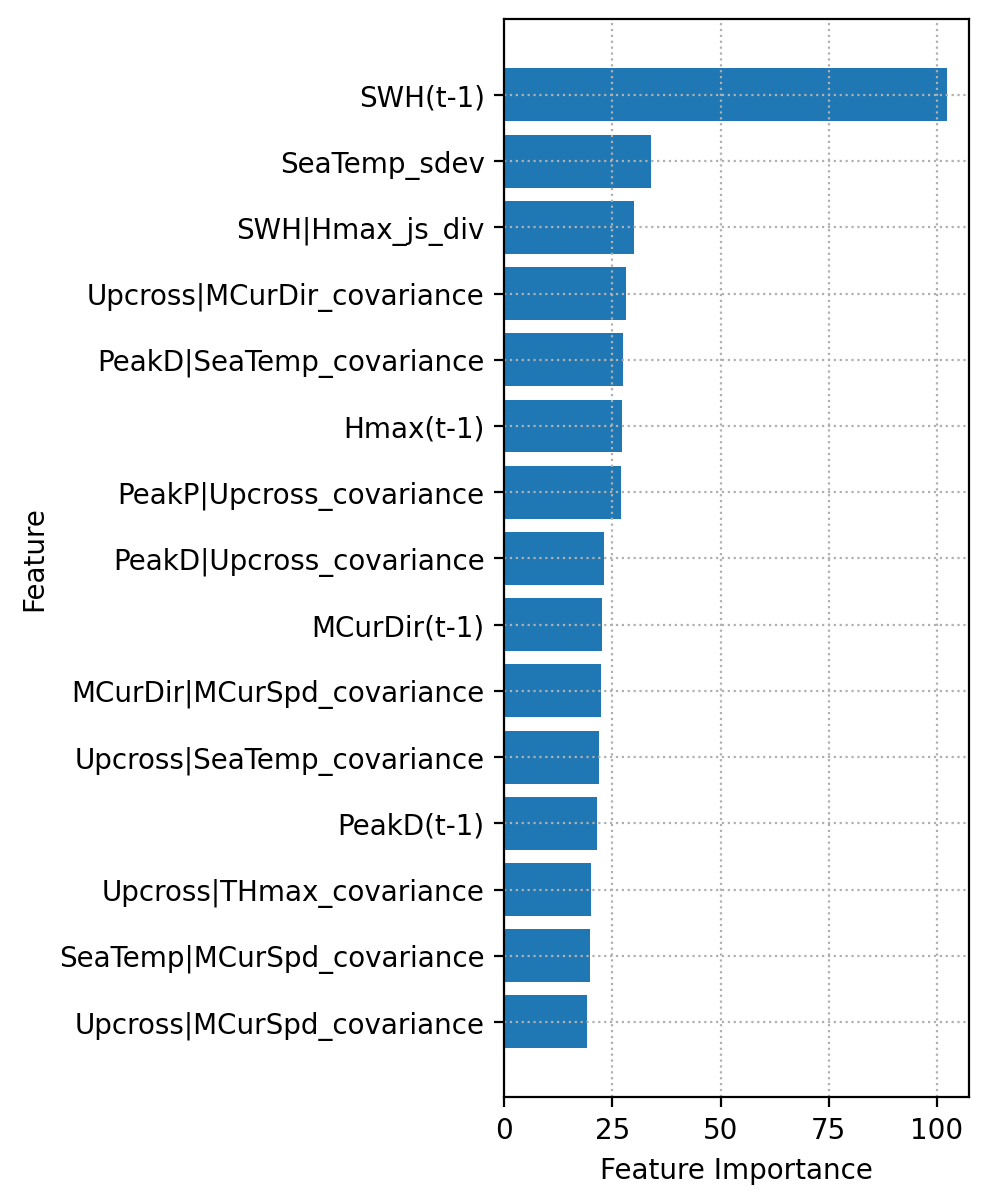

In [15]:
fig, ax = plt.subplots(figsize = (3, 7), dpi = 200)

# getting top 10 features
top_15_features = importance_scores.sort_values(ascending=False)[:15]
top_15_features_nm = top_15_features.index

ax.barh(top_15_features_nm, top_15_features)
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature')
ax.grid(linestyle = ':')
ax.invert_yaxis()
plt.show()

The most important feature is the first lag of the target variable. But, some of the extracted features are present in this top 15. For example, the third best feature in SWH|Hmax_js_div. This represents the Jensen-Shannon divergence between the lags of the target variable and the lags of Hmax. The fifth best feature is SeaTemp_sdev: the standard deviation sea temperature lags. The covariance is also a relevant statistic for different pairs of variables.

Another way to remove redundant features is to apply a correlation filter. You remove highly correlated features to reduce the dimension of the data.

#### **Summarising the Whole Time Series**
This guide focuses on forecasting problems with multivariate time series. So, the feature extraction process is applied to many subsequences of a time series. At each time step, you summarised the past 24 hours of data with a set of statistics.

But, you can also apply these statistics to characterize the whole time series in one go. This might be useful if your goal is to cluster a set of time series. First, you summarise each time series with feature extraction. Then, you apply a clustering algorithm to the resulting features.

### **Key Take-Aways**
- Multivariate time series forecasting is usually an auto-regressive process
- Feature engineering is a key step in data science projects.
- You can improve multivariate time series data sets with feature engineering. This includes computing univariate and bivariate transformations and summary statistics.
- Extracting too many features results in a high-dimensional problem. You can use feature selection methods to remove unwanted features.

Thanks for reading, and see you in the next story!

https://github.com/vcerqueira/blog